Programme avec tous les programmes du module de descente du gradient avec la minimisation de $\psi$ =sqrt($\rho$) plutot que $\rho$ directement.


Potentiel.py: contient les fonctions de calcul de listes pour différents potentiels (inchangée par rapport à MDG_taux)

In [27]:
import time

start_time = time.time()

import numpy as np
from math import pi,sqrt
d=1# decalage/shift
def pot_0(x):
    """ renvoie une liste de zéros pour le cas où on considère un fluide idéal sans perturbations extérieures"""
    return np.zeros(len(x))

def LJ(list_x, e, sigma):
    """ renvoie une liste de la taille de rho correspondant à un potentiel de LJ de paramètre e et sigma"""
    vext = np.array([])
    for i in range(len(list_x)):
        #on calcule le terme de LJ pour chaque x
        vext = np.append(vext, 4*e*((sigma/(list_x[i]))**12-(sigma/(list_x[i]))**6))
    return vext

def right_LJ(list_x,e, sigma ):
    """ renvoie une liste de la taille de rho correspondant à un potentiel de LJ A DROITE de paramètre e et sigma"""
    vext = np.array([])
    for i in range(len(list_x)):
        #on calcule le terme de LJ pour chaque x
        vext = np.append(vext, 4*e*((sigma/(list_x[-1]-list_x[i]+d))**12-(sigma/(list_x[-1]-list_x[i]+d))**6))
    return vext

def wall_LJ(list_x,e,sigma,wall_density=1):
    """ renvoie une liste de la taille de rho correspondant à l'interaction totale d'une particule de fluide 
    avec un mur de particules de densité donnée.
    Chaque interaction particule du fluide-particule du mur est modélisée par un  LJ de paramètre e et sigma."""
    vext = np.array([])
    for i in range(len(list_x)):
        #on calcule le terme de LJ pour chaque x
        vext = np.append(vext, 2/3*sigma**(3)*pi*e*wall_density*(2/15*(sigma/(list_x[i]))**9-(sigma/(list_x[i]))**3))
    return vext

def wall_LJ_right(list_x,e=1,sigma=1,wall_density=1):
    """ renvoie une liste de la taille de rho correspondant à l'interaction totale d'une particule de fluide 
    avec un mur de particules de densité donnée A DROITE.
    Chaque interaction particule du fluide-particule du mur est modélisée par un  LJ de paramètre e et sigma."""
    vext = np.array([])
    for i in range(len(list_x)):
        #on calcule le terme de LJ pour chaque x
        vext = np.append(vext, 2/3*sigma**(3)*pi*e*wall_density*(2/15*(sigma/(list_x[-1]-list_x[i]+d))**9-(sigma/(list_x[-1]-list_x[i]+d))**3))
    return vext

Functionnal.py: contient les fonctions de calcul des différents types d'énergie libre, ici fonctions de $\psi$

In [28]:
"""
import numpy as np
import Potentiel
"""



def Fid(rho, dx,forme):
    """ calcule la valeur de la fonctionnelle F idéale en fonction de rho,psi=sqrt(rho(x)) ou de log(rho) discrétisée avec un pas dx """
    #Fid = 0
    #for r in rho:
        #Fid += kb*T*dx*r*(np.log(r)-1)
    if forme=="rho":
        Fid = 1/beta*dx*np.sum(rho*(np.log(rho)-1))
    elif forme=="psi":
        Fid = 1/beta*dx*np.sum(np.square(rho)*(np.log(np.square(rho))-1))
    elif forme=="log":
        Fid = 1/beta*dx*np.sum(np.exp(rho)*(np.log(np.exp(rho))-1))
    else:
        print("erreur, la forme de fonction n'est pas valide")
        Fid=np.array([])
    return Fid
    

def Fext(rho, potentiel, dx,forme):
    """calcule la valeur de la fonctionnelle F extérieur en fonction de rho,psi=sqrt(rho(x)) ou de log(rho) et d'un potentiel extérieur entré en argument
    comme pour Fid, on a discrétisé avec un pas dx"""
    #Fext = 0
    #for i in range(len(rho)):
    #    Fext += dx*rho[i]*potentiel[i]
    if forme=="rho":
        Fext=dx*np.dot(rho,potentiel)
    elif forme=="psi":
        Fext=dx*np.dot(rho**(2),potentiel)
    elif forme=="log":
        Fext=dx*np.dot(np.exp(rho),potentiel)
    else:
        print("erreur, la forme de fonction n'est pas valide")
        Fext=np.array([])
    return Fext

def F(rho, potentiel, dx,forme):
    """somme simplement les deux fonctionnelles"""
    return Fid(rho,dx,forme) + Fext(rho, potentiel, dx,forme)


def rho_eq(potentiel):
    """ fonction de test (résultat théorique pour rho)"""
    #print(potentiel)
    rho = rho_bulk*np.exp(-1*potentiel*beta)

    return rho

GradientDescent.py: contient la fonction de calcul du gradient et l'algo de descente du gradient

In [29]:
"""import Potentiel as potloc='upper right'
import Functional"""
import matplotlib.pyplot as plt
import numpy as np
import os

def gradient(F, rho, potentiel, dx,  h = 10**(-6),forme="rho"):
    """ renvoie un array de la taille de psi correspondant au gradient de la fonctionnelle par rapport à psi(x)
    h est la valeur du delta pris pour la formule de dérivation """
    gradient = np.array([])
    
    for i in range(len(rho)):
        # pour chaque coordonnées de la liste rho, on crée la liste rho perturbé d'un h <<1 dans la direction de cette coordonnée
        rho_pert = rho.copy()
        rho_pert[i] = rho[i] + h
        # puis on calcule la différence entre les valeurs de f pour les deux listes (formule de la dérivée pour h->0)
        grad = (F(rho_pert, potentiel, dx,forme)-F(rho, potentiel, dx,forme))/(h)
        gradient = np.append(gradient, grad)

    return gradient



def gradient_descent(F, rho, potentiel, dx, x, learning_rate = 0.001, iterations = 100,forme="rho"):
    """applique l'algorithme de descente du gradient, visant à minimiser la fonctionnelle F[psi(x)].
    les outputs restent les mêmes que pour la descente de gradient pour rho
    Renvoie une liste g_final correspondant à la fonction rho(x)/rho_b minimisant cette fonctionnelle 
    ainsi qu'une liste de liste g pour différents nombres d'itérations 
    et enfin une liste des écarts entre 2 itérations pour observer la convergence """
    # on crée les listes pour stocker les valeurs que l'on souhaite plot
    energies =np.array([])
    list_ecart =  np.array([])
    list_rho= [rho]
    
    for i in range(iterations):
        grad = gradient(F, rho, potentiel, dx,h=10**(-6),forme=forme)
        for k in range(len(rho)):
                rho[k] = rho[k]-learning_rate*grad[k]
        if forme=="rho":
            for k in range(len(rho)):
                if rho[k]<= 0:
                    rho[k] = 10**(-6)      
        # affichage de la progression en pourcentage 
        pctage=i/iterations*100
        if pctage%5==0:
            print(f"{int(pctage)}%")
        if ((i/iterations)*100)%20 == 0  :
            
            rho=np.array([r for r in rho])
            list_rho = list_rho+[rho]
            
        if i>0:
            ecart =np.linalg.norm(rho-rho_i) 
            list_ecart  = np.append(list_ecart , ecart)
            
            # tentative de variation du learning rate
            """if ((i/iterations)*100)%10 == 0 :
                print(ecart)
                if ecart < learning_rate:
                    learning_rate=learning_rate/10
                elif ecart > learning_rate:
                    learning_rate=learning_rate*10
               """ 
        # on stocke le rho précédent pour pouvoir calculer la distance à la prochaine itération
        rho_i = rho.copy()
        
        energies=np.append(energies,F(rho, potentiel, dx,forme))
    #plt.xlim([0,2])
    #plt.ylim([20,25])
    rho_final = np.array([r for r in rho])
    list_g= []
    if forme=="rho":
        list_g=list_rho
        g_final=rho_final
    elif forme=="psi":
        g_final=np.square(rho_final)
        for rho in list_rho:
            g=np.square(rho)
            list_g=list_g+[g]
        
    elif forme=="log":
        g_final=np.exp(rho_final)
        for rho in list_rho:
            g=np.exp(rho)
            list_g=list_g+[g]
    
    
    print(f"learning rate: {learning_rate}")
    print(f"iterations: {iterations}")
    return g_final,list_g,list_ecart,energies





main.py 

In [30]:
# Constantes 
N = 500
x0 = 0
xf = 15
Na=6.022*10**(23)
e=1.8 
kb=1.380649*10**(-26) 
T=300
sigma=2.7
dx = (xf- x0)/N
beta=1/(Na*T*kb)

#beta=1/(Na*T*kb)
lambda_th=1
list_x = np.array([dx*i+1 for i in range(N)])
rho_bulk=0.033
rho_b = np.array([rho_bulk for i in range(len(list_x))])
psi_b=np.array([sqrt(rho_bulk) for i in range(len(list_x))])
iterations = int(3000)
learning_rate = 0.00045


##### PLOTS #####  
potentiel =wall_LJ_right(list_x,e,sigma)+wall_LJ(list_x,e,sigma)

#potentiel=LJ(list_x,e,sigma)
g_final3,list_g3,list_ecart3,energies3=gradient_descent(F, rho_b,potentiel, dx, list_x, learning_rate=0.000045,iterations=iterations,forme="log")
g_final,list_g,list_ecart,energies=gradient_descent(F, psi_b,potentiel, dx, list_x, learning_rate,iterations,forme="psi")
#g_final,list_g,list_ecart =gradient_descent(F, rho_b, LJ(list_x,e,sigma), dx, list_x, learning_rate,iterations)
g_final2,list_g2,list_ecart2,energies2=gradient_descent(F, rho_b,potentiel, dx, list_x, learning_rate=0.045,iterations=iterations,forme="rho")


#mesure de temps de compilation
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time,"s")


0%
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
60%
65%
70%
75%
80%
85%
90%
95%
learning rate: 4.5e-05
iterations: 3000
0%
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
60%
65%
70%
75%
80%
85%
90%
95%
learning rate: 0.00045
iterations: 3000
0%


<ipython-input-28-29ea213b2a07>:14: RuntimeWarning: invalid value encountered in log
  Fid = 1/beta*dx*np.sum(rho*(np.log(rho)-1))


5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
60%
65%
70%
75%
80%
85%
90%
95%
learning rate: 0.045
iterations: 3000
224.24637818336487 s


Partie des plots graphiques:  on affiche la densité puis l'évolution des écarts et enfin celle de l'énergie libre

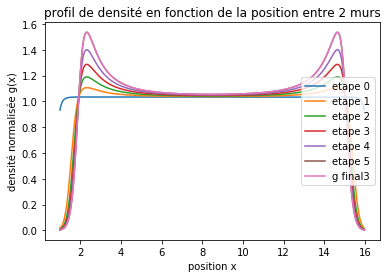

In [42]:

# COurbe 1 : Profil de densité
plt.figure(1)
#expression attendue
"""rho0=rho_eq(potentiel)
g_eq=np.array([r/0.033 for r in rho0])
plt.plot(list_x,g_eq,label='g0')"""

for k in range(len(list_g3)):
    plt.plot(list_x,list_g3[k],label=f'etape {k}')
#plt.plot(list_x,g_final,label='g final')
#plt.plot(list_x,g_final2,label='psi')
plt.plot(list_x,g_final3,label='g final3')
plt.title("profil de densité en fonction de la position entre 2 murs")
plt.ylabel("densité normalisée g(x)")
plt.xlabel("position x")
plt.legend(loc='right')



# enregistrement des figures 1
"""subdirectory = f"plots test/ MDG_taux"
os.makedirs(subdirectory, exist_ok=True)
filename = f"Profil densité pour N={N},un taux de {learning_rate} pour {iterations} itérations,sigma={sigma} et e={e}.png"
filepath = os.path.join(subdirectory, filename)
plt.savefig(filepath)"""

plt.show()



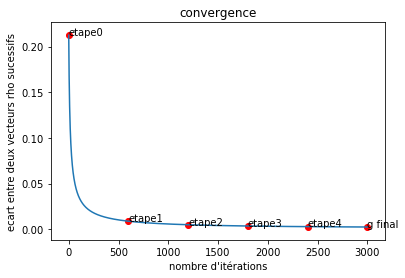

In [43]:

#Courbe 2 : Convergence
list_ecart=list_ecart3
list_iterations = np.array([i for i in range(len(list_ecart))])
plt.figure(2)
plt.title("convergence")
plt.ylabel("ecart entre deux vecteurs rho sucessifs")
plt.xlabel("nombre d'itérations")
#plt.xscale('log')
plt.plot(list_iterations, list_ecart)
hl_x=[]
hl_y=[]
for i in range(iterations):
    if ((i/iterations)*100)%20 == 0  :
        
        hl_x.append(list_iterations[i])
        hl_y.append(list_ecart[i]) 
hl_x.append(list_iterations[iterations-2])
hl_y.append(list_ecart[iterations-2]) 
plt.scatter(hl_x, hl_y, color='r', label='Etapes')
for k in range(len(hl_x)-1):
    plt.text(hl_x[k],hl_y[k],f"etape{k}")
plt.text(hl_x[len(hl_x)-1],hl_y[len(hl_x)-1],f"g final")

plt.plot(list_iterations, list_ecart2)
# enregistrement des figures 2
"""filename = f"Convergence pour N={N},un taux de {learning_rate} pour {iterations} itérations .png"
filepath = os.path.join(subdirectory, filename)
plt.savefig(filepath)"""
plt.show()

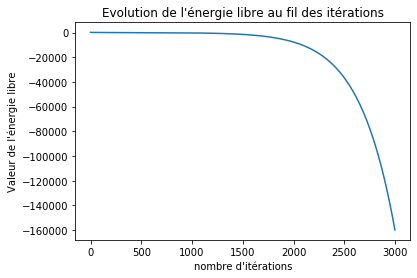

In [33]:

#Courbe 3 : Energie libre 
list_iterations = np.array([i for i in range(len(energies))])
plt.figure(3)
plt.title("Evolution de l'énergie libre au fil des itérations")
plt.ylabel("Valeur de l'énergie libre")
plt.xlabel("nombre d'itérations")
#plt.xscale('log')
plt.plot(list_iterations, energies)
plt.plot(list_iterations, energies2)
plt.show()

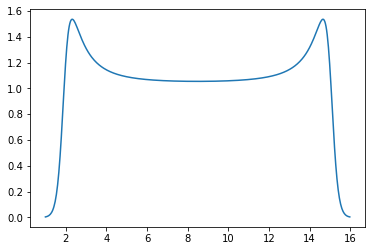

In [34]:
plt.plot(list_x,g_final3,label='g final')
"""plt.xlim([0,16])
plt.ylim([0,2])"""
plt.show()

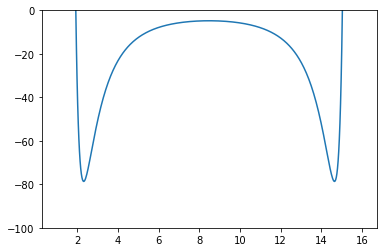

In [35]:
plt.plot(list_x,potentiel)
plt.ylim([-100,0])
plt.show()

In [36]:
print(max(g_final))

3639.7555100098302


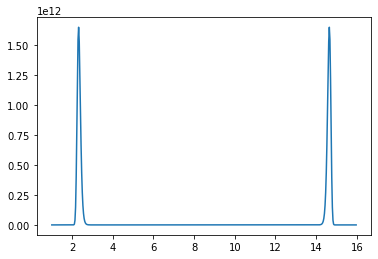

In [37]:
plt.plot(list_x,rho_eq(potentiel))

plt.show()